In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.path.abspath(".")

import utils
import visualize
from visualize import display_images
import model as modellib
from config import Config
from model import log
import detector

import seaborn as sns
import pandas as pd

import imgaug as ia
from imgaug import augmenters as iaa
import imageio


%matplotlib inline

Using TensorFlow backend.


C:\Users\blais\TACO-master\TACO-master\detector\models\logs


In [2]:
print(ROOT_DIR)
MODEL_DIR=os.path.join(ROOT_DIR, "models\logs")
print(MODEL_DIR)

COCO_MODEL_PATH=os.path.join(ROOT_DIR, "models\mask_rcnn_taco0100.h5")
print(COCO_MODEL_PATH)

C:\Users\blais\TACO-master\TACO-master\detector
C:\Users\blais\TACO-master\TACO-master\detector\models\logs
C:\Users\blais\TACO-master\TACO-master\detector\models\mask_rcnn_taco0100.h5


In [3]:
import csv
import dataset

# Load class map - these tables map the original TACO classes to your desired class system
# and allow you to discard classes that you don't want to include.
class_map = {}
with open("./taco_config/map_10.csv") as csvfile:
    reader = csv.reader(csvfile)
    class_map = {row[0]:row[1] for row in reader}

# Load full dataset or a subset
TACO_DIR = "../data"
round = None # Split number: If None, loads full dataset else if int > 0 selects split no 
subset = "test" # Used only when round !=None, Options: ('train','val','test') to select respective subset
dataset = dataset.Taco()
taco = dataset.load_taco(TACO_DIR, round, subset, class_map=class_map, return_taco=True)

# Must call before using the dataset
dataset.prepare()

print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))
    


creating index...
index created!
Number of images used: 1500
Class Count: 11
  0. BG                                                
  1. Bottle                                            
  2. Bottle cap                                        
  3. Can                                               
  4. Cigarette                                         
  5. Cup                                               
  6. Lid                                               
  7. Other                                             
  8. Plastic bag + wrapper                             
  9. Pop tab                                           
 10. Straw                                             


In [13]:
class TacoTestConfig(Config):
    NAME = "taco"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 10
    NUM_CLASSES = dataset.num_classes
config = TacoTestConfig()

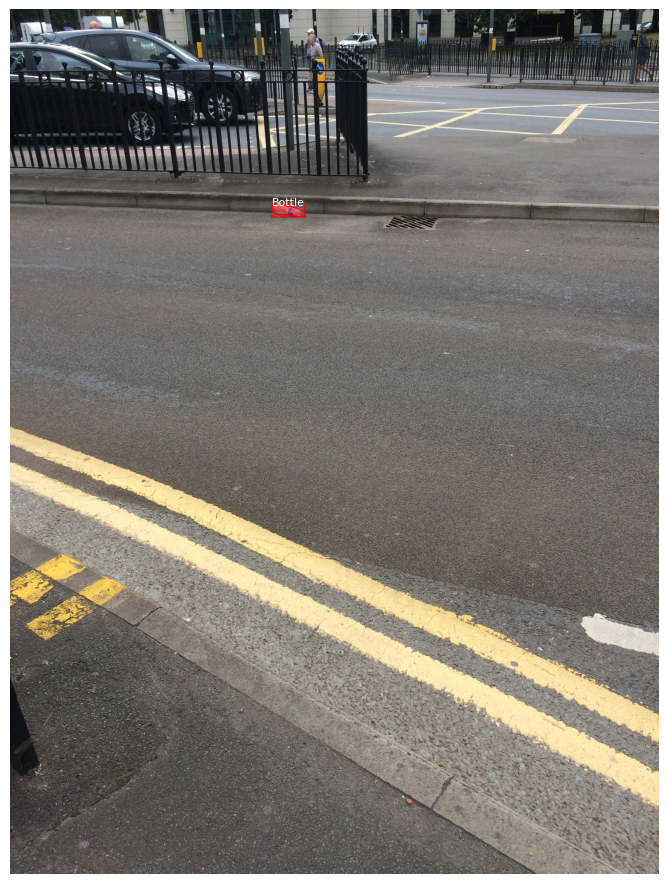

In [14]:
image_id = np.random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
bbox = utils.extract_bboxes(mask)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [15]:
#utils.download_trained_weights(COCO_MODEL_PATH)

In [16]:
model=modellib.MaskRCNN(mode="inference", config=config, model_dir=MODEL_DIR)

print(MODEL_DIR)

model_path="./models/logs/mask_rcnn_taco_0100.h5"


C:\Users\blais\TACO-master\TACO-master\detector\models\logs


In [17]:
#model.load_weights(weights_in_path=model_path, weights_out_path=model_path, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox","mrcnn_mask"])
model.load_weights(weights_in_path=model_path, weights_out_path=model_path, by_name=True)

In [18]:
orimage, meta, class_ids, bbox, mask=modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)

In [19]:
results=model.detect([orimage], verbose=1)
r=results[0]

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 23)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


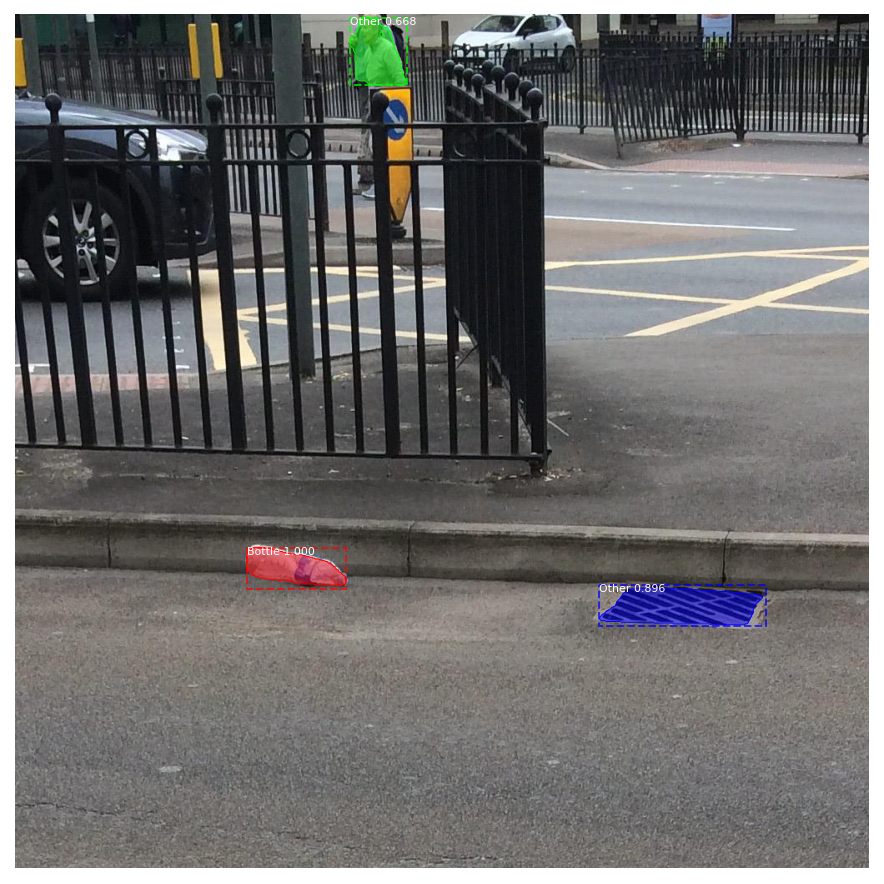

In [20]:
visualize.display_instances(orimage, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'])

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 23)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


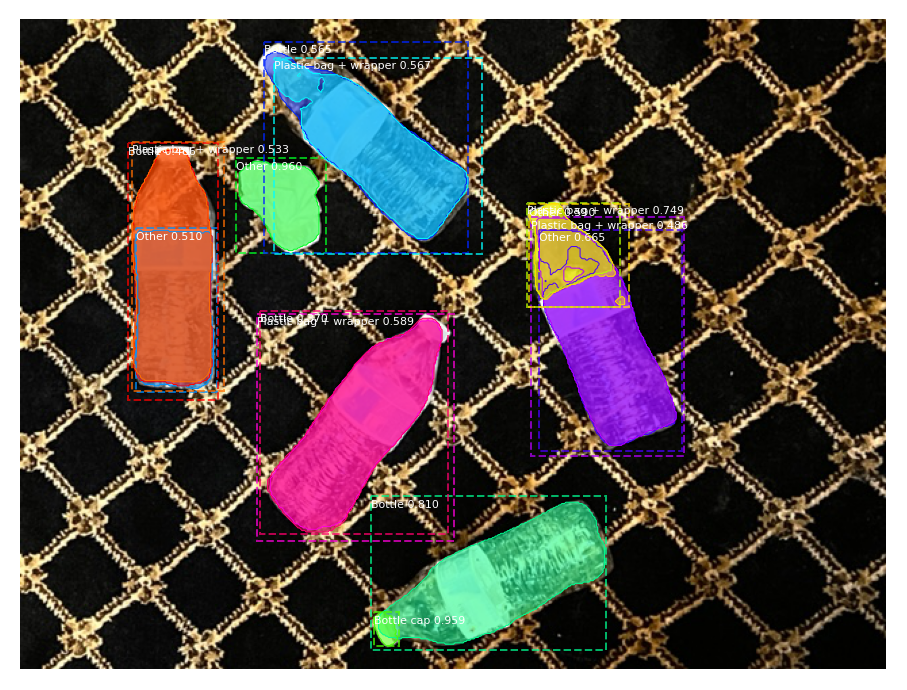

In [21]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
#to test own images, replace the file path
orimage=load_img("C:/Users/blais/Internship/TACO-master/TACO-master/data/bottles.jpg")
orimage=img_to_array(orimage)

results=model.detect([orimage], verbose=1)
r=results[0]
visualize.display_instances(orimage, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'])